In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('../data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [3]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [4]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [5]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [6]:
ICM_df = pd.read_csv('../data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [7]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [8]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [9]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

In [10]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])


In [12]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender_itemKNN = ItemKNNCFRecommender(URM_train)
recommender_itemKNN.fit(shrink=550, topK=500, feature_weighting = 'TF-IDF', similarity = 'cosine')
evaluator_validation.evaluateRecommender(recommender_itemKNN)

ItemKNNCFRecommender: URM Detected 70 (0.88 %) cold users.
ItemKNNCFRecommender: URM Detected 2383 (9.17 %) cold items.
Similarity column 25975 ( 100 % ), 4142.80 column/sec, elapsed time 0.10 min
EvaluatorHoldout: Processed 5650 ( 100.00% ) in 5.30 sec. Users per second: 1066


({10: {'ROC_AUC': 0.1606509130495859,
   'PRECISION': 0.03384070796460108,
   'PRECISION_RECALL_MIN_DEN': 0.11497022053659245,
   'RECALL': 0.11127565663886223,
   'MAP': 0.05268973111860271,
   'MRR': 0.11815528866413831,
   'NDCG': 0.08110475867228434,
   'F1': 0.051898309472880634,
   'HIT_RATE': 0.3384070796460177,
   'ARHR': 0.13591571849978962,
   'NOVELTY': 0.0051086654782935195,
   'AVERAGE_POPULARITY': 0.06366859366010025,
   'DIVERSITY_MEAN_INTER_LIST': 0.993706333801738,
   'DIVERSITY_HERFINDAHL': 0.9993530456574516,
   'COVERAGE_ITEM': 0.5144947064485081,
   'COVERAGE_ITEM_CORRECT': 0.04396535129932627,
   'COVERAGE_USER': 0.7109601107336102,
   'COVERAGE_USER_CORRECT': 0.18044545111362778,
   'DIVERSITY_GINI': 0.1964351177806062,
   'SHANNON_ENTROPY': 12.277705024660824}},
 'CUTOFF: 10 - ROC_AUC: 0.1606509, PRECISION: 0.0338407, PRECISION_RECALL_MIN_DEN: 0.1149702, RECALL: 0.1112757, MAP: 0.0526897, MRR: 0.1181553, NDCG: 0.0811048, F1: 0.0518983, HIT_RATE: 0.3384071, ARHR:

In [13]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_userKNN = UserKNNCFRecommender(URM_train)
recommender_userKNN.fit(shrink=50, topK=100, feature_weighting = "TF-IDF")

evaluator_validation.evaluateRecommender(recommender_userKNN)

UserKNNCFRecommender: URM Detected 70 (0.88 %) cold users.
UserKNNCFRecommender: URM Detected 2383 (9.17 %) cold items.
Similarity column 7947 ( 100 % ), 8944.42 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 5650 ( 100.00% ) in 5.38 sec. Users per second: 1051


({10: {'ROC_AUC': 0.15905910942548152,
   'PRECISION': 0.03472566371681342,
   'PRECISION_RECALL_MIN_DEN': 0.11691613990729058,
   'RECALL': 0.11276709032650718,
   'MAP': 0.05384898792522566,
   'MRR': 0.11793608652900692,
   'NDCG': 0.0821206224828431,
   'F1': 0.05309972116801963,
   'HIT_RATE': 0.3472566371681416,
   'ARHR': 0.13626106194690285,
   'NOVELTY': 0.0048981661671642,
   'AVERAGE_POPULARITY': 0.08791051809638596,
   'DIVERSITY_MEAN_INTER_LIST': 0.9898080982302452,
   'DIVERSITY_HERFINDAHL': 0.9989632910956222,
   'COVERAGE_ITEM': 0.40592877767083735,
   'COVERAGE_ITEM_CORRECT': 0.04184793070259865,
   'COVERAGE_USER': 0.7109601107336102,
   'COVERAGE_USER_CORRECT': 0.18220712218447213,
   'DIVERSITY_GINI': 0.12811959030936657,
   'SHANNON_ENTROPY': 11.572702875909162}},
 'CUTOFF: 10 - ROC_AUC: 0.1590591, PRECISION: 0.0347257, PRECISION_RECALL_MIN_DEN: 0.1169161, RECALL: 0.1127671, MAP: 0.0538490, MRR: 0.1179361, NDCG: 0.0821206, F1: 0.0530997, HIT_RATE: 0.3472566, ARHR: 

In [14]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
recommender_SVD = PureSVDRecommender(URM_train)
recommender_SVD.fit(num_factors = 825)

evaluator_validation.evaluateRecommender(recommender_SVD)

PureSVDRecommender: URM Detected 70 (0.88 %) cold users.
PureSVDRecommender: URM Detected 2383 (9.17 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
EvaluatorHoldout: Processed 5650 ( 100.00% ) in 10.84 sec. Users per second: 521


({10: {'ROC_AUC': 0.10100078662733547,
   'PRECISION': 0.020336283185840492,
   'PRECISION_RECALL_MIN_DEN': 0.07283733670459329,
   'RECALL': 0.07109636169682908,
   'MAP': 0.031860871979076756,
   'MRR': 0.07116863323500482,
   'NDCG': 0.05002851059858118,
   'F1': 0.03162624786376944,
   'HIT_RATE': 0.2033628318584071,
   'ARHR': 0.07918815844922032,
   'NOVELTY': 0.005067146786940715,
   'AVERAGE_POPULARITY': 0.04386065371654012,
   'DIVERSITY_MEAN_INTER_LIST': 0.996629686200236,
   'DIVERSITY_HERFINDAHL': 0.999645329156551,
   'COVERAGE_ITEM': 0.34537054860442734,
   'COVERAGE_ITEM_CORRECT': 0.03657362848893166,
   'COVERAGE_USER': 0.7109601107336102,
   'COVERAGE_USER_CORRECT': 0.11664779161947905,
   'DIVERSITY_GINI': 0.13429236517847654,
   'SHANNON_ENTROPY': 12.132297498702673}},
 'CUTOFF: 10 - ROC_AUC: 0.1010008, PRECISION: 0.0203363, PRECISION_RECALL_MIN_DEN: 0.0728373, RECALL: 0.0710964, MAP: 0.0318609, MRR: 0.0711686, NDCG: 0.0500285, F1: 0.0316262, HIT_RATE: 0.2033628, ARH

In [15]:
from KNN.ItemKNNScoresHybrid4Recommender import ItemKNNScoresHybrid4Recommender



hybridrecommender = ItemKNNScoresHybrid4Recommender(URM_train, recommender_CBF, recommender_itemKNN, recommender_userKNN, recommender_SVD)
hybridrecommender.fit(first = 0.6, second = 0.2, third = 0.1)

evaluator_validation.evaluateRecommender(hybridrecommender)

NameError: name 'recommender_CBF' is not defined

In [42]:
x_tick = []
collaborative_MAP = []

for first in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for second in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        for third in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            x_tick.append("first {}, second{}, third{}".format(first,second,third))



            hybridrecommender = ItemKNNScoresHybrid4Recommender(URM_train, recommender_CBF, recommender_itemKNN, recommender_userKNN, recommender_SVD)
            hybridrecommender.fit(first=first, second=second, third=third)

            result_dict, _ = evaluator_validation.evaluateRecommender(hybridrecommender)

            collaborative_MAP.append(result_dict[10]["MAP"])

ItemKNNScoresHybrid5Recommender: URM Detected 75 (0.94 %) cold users.
ItemKNNScoresHybrid5Recommender: URM Detected 2389 (9.20 %) cold items.
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (649, 25975)
EvaluatorHoldout: Processed 5649 ( 100.00% ) in 14.33 sec. Users per second: 394
ItemKNNScoresHybrid5Recommender: URM Detected 75 (0.94 %) cold users.
ItemKNNScoresHybrid5Recommender: URM Detected 2389 (9.20 %) cold items.
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (649, 25975)
EvaluatorHoldout: Processed 5649 ( 100.00% ) in 15.11 sec. Users per second: 374
ItemKNNScoresHybrid5Recommender: URM Detected 75 (0.94 %) cold users.
ItemKNNScoresHybrid5Recommender: URM Detec

KeyboardInterrupt: 

In [17]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

63 0.06958306327701759
alpha 0.8, beta0.1


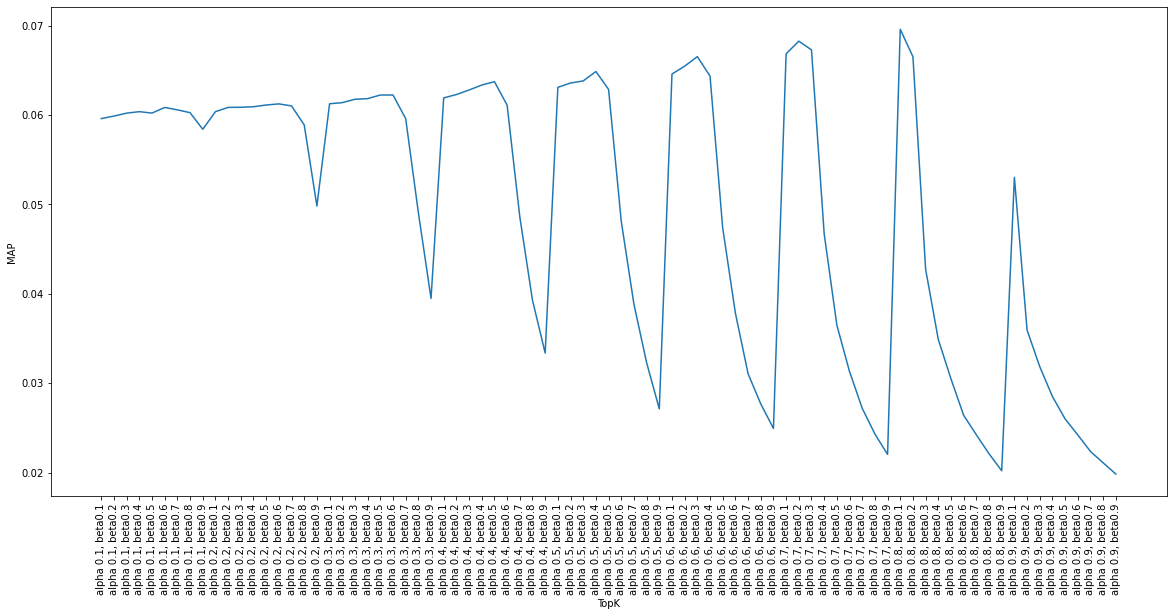

In [18]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(20, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [16]:
test_users = pd.read_csv('../data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [17]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from KNN.ItemKNNScoresHybrid4Recommender import ItemKNNScoresHybrid4Recommender


recommender_CBF = ItemKNNCBFRecommender(URM_all, ICM_all)
recommender_CBF.fit(topK=625, shrink=50, feature_weighting = 'TF-IDF')


recommender_itemKNN = ItemKNNCFRecommender(URM_all)
recommender_itemKNN.fit(shrink=550, topK=500, feature_weighting = 'TF-IDF', similarity = 'cosine')

recommender_userKNN = UserKNNCFRecommender(URM_all)
recommender_userKNN.fit(shrink=50, topK=100, feature_weighting = "TF-IDF")

recommender_SVD = PureSVDRecommender(URM_all)
recommender_SVD.fit(num_factors = 825)

hybridrecommender = ItemKNNScoresHybrid4Recommender(URM_all, recommender_CBF, recommender_itemKNN, recommender_userKNN, recommender_SVD)
hybridrecommender.fit(first = 0.9, second = 0.2, third = 0.1)

user_id = test_users['user_id']
recommendations = hybridrecommender.recommend(user_id,cutoff = 10)

ItemKNNCBFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 2417.43 column/sec, elapsed time 0.18 min
ItemKNNCFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 3740.67 column/sec, elapsed time 0.12 min
UserKNNCFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 7947 ( 100 % ), 10511.20 column/sec, elapsed time 0.01 min
PureSVDRecommender: URM Detected 1079 (4.15 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
ItemKNNScoresHybrid5Recommender: URM Detected 1079 (4.15 %) cold items.
shape of item_weights: (7944, 25975)


In [18]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [19]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
